In [3]:
import psycopg2
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [4]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

In [5]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()


In [6]:
query = """
select
   date(ctp.tracking_time) as preload_date
   , date(cti.tracking_time) as install_date
   , case 
       when s.site_name like '%S20%' then 'S20'
       when s.site_name like '%S21%' then 'S21'
       when s.site_name like '%Note 20%' then 'Note 20'
   end as device_group
   , count(distinct ctp.referrer) as preloads
   , count(distinct cti.referrer) as installs
from rawdata.campaign_tracking_active_preload ctp
join rawdata.site s
    on ctp.site_id = s.site_id 
left join rawdata.campaign_tracking_active_install cti 
    on ctp.referrer = cti.referrer 
    and date(cti.tracking_time) >= date('02-01-2021')    
where
    date(ctp.tracking_time) >= date('02-01-2021')
    and date(ctp.tracking_time) <= date('03-03-2021')
    and (
        s.site_name like '%S20%'
        or s.site_name like '%S21%'
        or s.site_name like '%Note 20%'
    )
group by 1,2,3
"""

In [7]:
cur_atlas.execute(query)
df = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

<AxesSubplot:xlabel='TTI'>

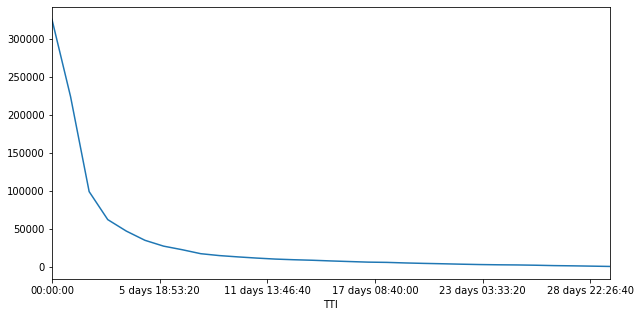

In [8]:
df['TTI'] = (df['install_date'] - df['preload_date'])
df['TTI']
df[(df.TTI >= datetime.timedelta(days = 0)) & (df.TTI <= datetime.timedelta(days = 30))].groupby('TTI')['installs'].sum().plot(figsize = (10,5))

In [37]:
cohort_days = 7

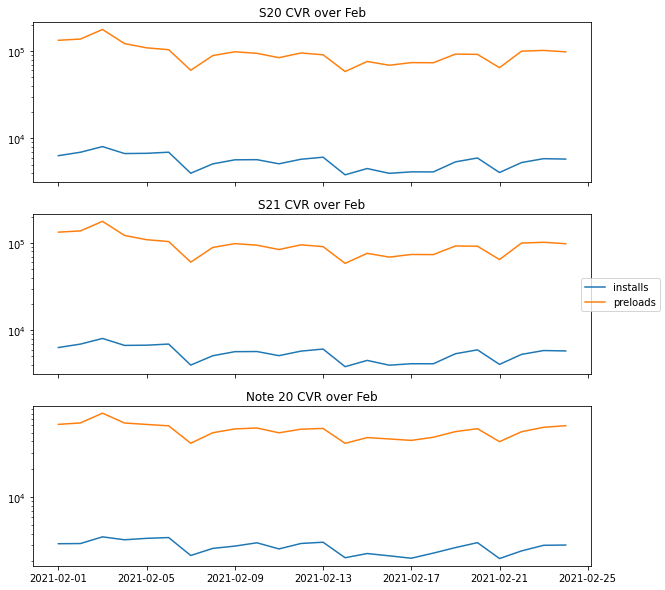

In [39]:
filters = ((df.TTI <= datetime.timedelta(days = cohort_days)) | (df.TTI.isna())) & (df.preload_date <= (datetime.date.today() - datetime.timedelta(cohort_days+1)))
device_pivot = df[filters].pivot_table(values = ['preloads','installs'], index = 'preload_date', columns = 'device_group',aggfunc = np.sum)

fig, ax = plt.subplots(3,1, figsize = (10,10), sharex='all')
ax[0].plot(device_pivot.xs('S20', axis = 1, level = 1))
ax[0].set_yscale('log')
ax[0].set_title('S20 CVR over Feb')
ax[1].plot(device_pivot.xs('S20', axis = 1, level = 1))
ax[1].set_yscale('log')
ax[1].set_title('S21 CVR over Feb')
ax[2].plot(device_pivot.xs('Note 20', axis = 1, level = 1))
ax[2].set_yscale('log')
ax[2].set_title('Note 20 CVR over Feb')
fig.legend(['installs','preloads'], loc = 'right')


<AxesSubplot:xlabel='preload_date'>

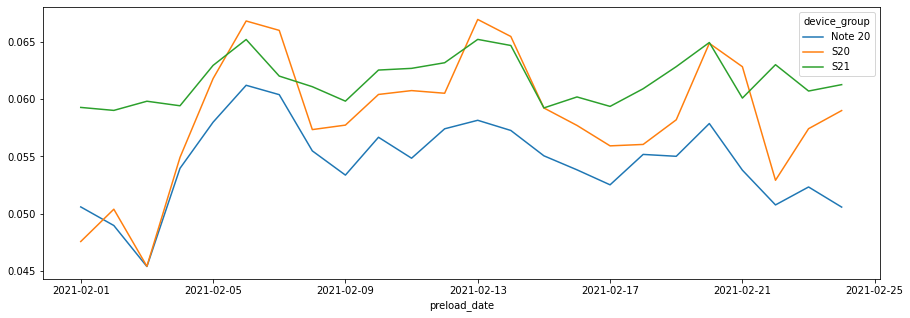

In [40]:
#device_pivot.columns
for device_group in device_pivot.columns.get_level_values(1):
    device_pivot[('cvr',device_group)] = device_pivot[('installs',device_group)]/device_pivot[('preloads',device_group)]
device_pivot['cvr'].plot(figsize=(15,5))